## Teste Visualização de Curva ROC

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report

In [4]:
import pandas as pd
import numpy as np

# Definindo a semente para reprodutibilidade
np.random.seed(42)

# Número de registros
n_records = 5000

# Gerando as variáveis
idade = np.random.randint(18, 70, size=n_records)  # Idade entre 18 e 70 anos
salario = np.random.normal(5000, 2000, size=n_records)  # Salário com média 5000 e desvio padrão 2000
tempo_emprego = np.random.normal(5, 3, size=n_records)  # Tempo de emprego com média 5 anos e desvio 3
score_credito = np.random.normal(600, 150, size=n_records)  # Score de crédito com média 600 e desvio 150
limite_cartao = np.random.normal(10000, 5000, size=n_records)  # Limite de cartão com média 10000 e desvio 5000
dividas = np.random.randint(0, 10, size=n_records)  # Dívidas de 0 a 10
possui_carro = np.random.choice(['sim', 'nao'], size=n_records, p=[0.6, 0.4])  # 60% com carro
possui_casa = np.random.choice(['sim', 'nao'], size=n_records, p=[0.7, 0.3])  # 70% com casa
estado_civil = np.random.choice(['solteiro', 'casado', 'divorciado'], size=n_records, p=[0.4, 0.5, 0.1])  # Estado civil
numero_dependentes = np.random.randint(0, 5, size=n_records)  # Número de dependentes entre 0 e 5
renda_extra = np.random.randint(0, 2, size=n_records)  # Renda extra (0 ou 1)
concede_credito = np.random.choice([0, 1], size=n_records)  # 50% de conceder crédito (balanceado)

# Criando o DataFrame
df = pd.DataFrame({
    'idade': idade,
    'salario': salario,
    'tempo_emprego': tempo_emprego,
    'score_credito': score_credito,
    'limite_cartao': limite_cartao,
    'dividas': dividas,
    'possui_carro': possui_carro,
    'possui_casa': possui_casa,
    'estado_civil': estado_civil,
    'numero_dependentes': numero_dependentes,
    'renda_extra': renda_extra,
    'concede_credito': concede_credito
})

# Ajustando para balancear as classes (concede_credito)
class_0 = df[df['concede_credito'] == 0]
class_1 = df[df['concede_credito'] == 1]

# Para balancear, pegamos a menor classe e repetimos os registros da outra classe
n_class_1 = class_1.shape[0]
class_0_balanced = class_0.sample(n=n_class_1, replace=True, random_state=42)

# Concatenando as classes balanceadas
df_balanced = pd.concat([class_0_balanced, class_1])

# Embaralhando os registros
df = df_balanced.sample(frac=1, random_state=42).reset_index(drop=True)

# Visualizando as primeiras linhas do dataset gerado
df.head()


,idade,salario,tempo_emprego,score_credito,limite_cartao,dividas,possui_carro,possui_casa,estado_civil,numero_dependentes,renda_extra,concede_credito
0,22,6415.084702,5.204398,656.168821,3239.393397,5,sim,sim,casado,2,0,0
1,43,3138.671564,0.851312,427.876438,10649.353336,7,sim,nao,casado,4,0,0
2,62,2664.696436,-2.329436,554.225655,13028.624804,2,sim,nao,solteiro,2,0,1
3,41,5936.631170,4.040070,657.410943,7727.355138,6,nao,sim,casado,1,1,0
4,48,7364.468058,4.549244,668.281237,5005.931445,9,nao,nao,solteiro,1,0,0


In [5]:
df.shape

(5138, 12)

In [6]:
df.head()

,idade,salario,tempo_emprego,score_credito,limite_cartao,dividas,possui_carro,possui_casa,estado_civil,numero_dependentes,renda_extra,concede_credito
0,22,6415.084702,5.204398,656.168821,3239.393397,5,sim,sim,casado,2,0,0
1,43,3138.671564,0.851312,427.876438,10649.353336,7,sim,nao,casado,4,0,0
2,62,2664.696436,-2.329436,554.225655,13028.624804,2,sim,nao,solteiro,2,0,1
3,41,5936.631170,4.040070,657.410943,7727.355138,6,nao,sim,casado,1,1,0
4,48,7364.468058,4.549244,668.281237,5005.931445,9,nao,nao,solteiro,1,0,0


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5138 entries, 0 to 5137
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   idade               5138 non-null   int32  
 1   salario             5138 non-null   float64
 2   tempo_emprego       5138 non-null   float64
 3   score_credito       5138 non-null   float64
 4   limite_cartao       5138 non-null   float64
 5   dividas             5138 non-null   int32  
 6   possui_carro        5138 non-null   object 
 7   possui_casa         5138 non-null   object 
 8   estado_civil        5138 non-null   object 
 9   numero_dependentes  5138 non-null   int32  
 10  renda_extra         5138 non-null   int32  
 11  concede_credito     5138 non-null   int64  
dtypes: float64(4), int32(4), int64(1), object(3)
memory usage: 401.5+ KB


In [8]:
#Tranformando variáveis categóricas em numéricas para melhor visualização dos dados e aplicação da biblioteca DecisionTreeClassifier
from sklearn.preprocessing import OneHotEncoder

In [9]:
encoder = OneHotEncoder(sparse_output =False, drop='first')  # `sparse=False` para retornar uma matriz densa
encoded_data = encoder.fit_transform(df[['possui_carro', 'possui_casa', 'estado_civil']])
encoded_df = pd.DataFrame(encoded_data, columns=encoder.get_feature_names_out(['possui_carro', 'possui_casa', 'estado_civil']))
df = pd.concat([df.drop(['possui_carro', 'possui_casa', 'estado_civil'], axis=1), encoded_df], axis=1)


In [10]:
# Reordenando as colunas
target = 'concede_credito'
df = df[[col for col in df.columns if col != target]+[target]]

In [11]:
df.head()

,idade,salario,tempo_emprego,score_credito,limite_cartao,dividas,numero_dependentes,renda_extra,possui_carro_sim,possui_casa_sim,estado_civil_divorciado,estado_civil_solteiro,concede_credito
0,22,6415.084702,5.204398,656.168821,3239.393397,5,2,0,1.0,1.0,0.0,0.0,0
1,43,3138.671564,0.851312,427.876438,10649.353336,7,4,0,1.0,0.0,0.0,0.0,0
2,62,2664.696436,-2.329436,554.225655,13028.624804,2,2,0,1.0,0.0,0.0,1.0,1
3,41,5936.631170,4.040070,657.410943,7727.355138,6,1,1,0.0,1.0,0.0,0.0,0
4,48,7364.468058,4.549244,668.281237,5005.931445,9,1,0,0.0,0.0,0.0,1.0,0


In [12]:
df.describe()

,idade,salario,tempo_emprego,score_credito,limite_cartao,dividas,numero_dependentes,renda_extra,possui_carro_sim,possui_casa_sim,estado_civil_divorciado,estado_civil_solteiro,concede_credito
count,5138.000000,5138.000000,5138.000000,5138.000000,5138.000000,5138.000000,5138.000000,5138.000000,5138.000000,5138.000000,5138.000000,5138.000000,5138.000000
mean,43.706890,4970.427971,4.926507,604.676524,9979.643593,4.604905,2.007007,0.507980,0.609381,0.704165,0.102374,0.416115,0.500000
std,14.874667,2016.386393,3.033471,150.645928,5023.245949,2.868270,1.421062,0.499985,0.487937,0.456462,0.303170,0.492961,0.500049
min,18.000000,-2164.125215,-6.272306,-2.868174,-7704.805732,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,31.000000,3635.885928,2.900334,503.418802,6666.188393,2.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,44.000000,4922.623441,4.924347,610.159559,9861.104446,5.000000,2.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.500000
75%,56.000000,6319.132508,6.996730,706.330339,13284.453490,7.000000,3.000000,1.000000,1.000000,1.000000,0.000000,1.000000,1.000000
max,69.000000,11552.798690,15.632195,1166.623496,29033.586831,9.000000,4.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [13]:
#Verifica se há valores nulos
df.isnull().sum()

idade                      0
salario                    0
tempo_emprego              0
score_credito              0
limite_cartao              0
dividas                    0
numero_dependentes         0
renda_extra                0
possui_carro_sim           0
possui_casa_sim            0
estado_civil_divorciado    0
estado_civil_solteiro      0
concede_credito            0
dtype: int64

In [14]:
#Verifica se há duplicados
df.duplicated().sum()

np.int64(1009)

In [15]:
#Verifica quantos valores distintos há em cada coluna
df.nunique()

idade                        52
salario                    4129
tempo_emprego              4129
score_credito              4129
limite_cartao              4129
dividas                      10
numero_dependentes            5
renda_extra                   2
possui_carro_sim              2
possui_casa_sim               2
estado_civil_divorciado       2
estado_civil_solteiro         2
concede_credito               2
dtype: int64

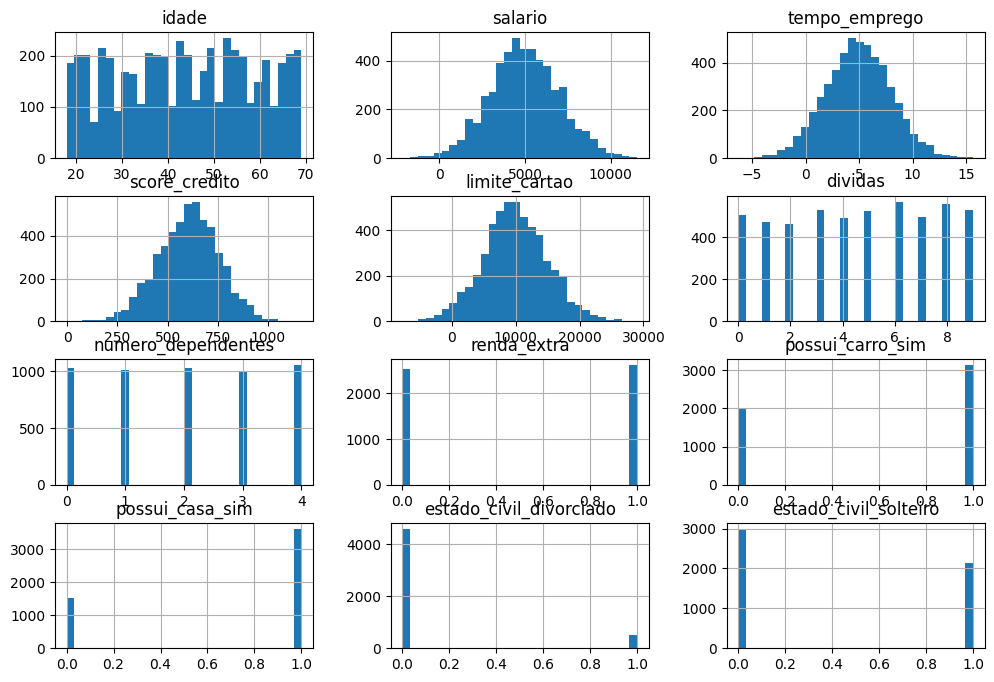

In [16]:
#analisando distribuição das variáveis numéricas
num_vars = ["idade", "salario", "tempo_emprego", "score_credito", "limite_cartao", "dividas", 'numero_dependentes', 'renda_extra', 'possui_carro_sim','possui_casa_sim', 'estado_civil_divorciado', 'estado_civil_solteiro']
df[num_vars].hist(figsize=(12, 8), bins=30)
plt.show()

Conclusão

Distribuição normal:
- idade
- tempo de emprego
- limite_cartao

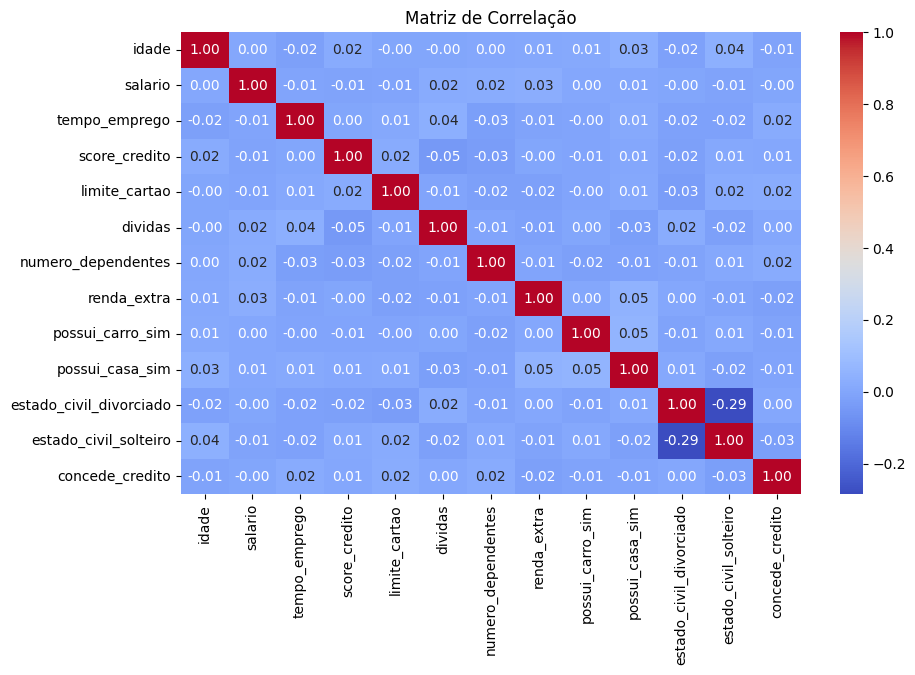

In [17]:
#analisando correlação entre as features
plt.figure(figsize=(10, 6))
sns.heatmap(df.corr(numeric_only=True), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Matriz de Correlação")
plt.show()

Conclusão: 

Features correlacionadas:

- limite_cartao x tempo_emprego
- salario x limite_cartao

Feature correlacionadas ao target:

- tempo_emprego
- renda_extra
- dividas

Outliers em idade: 0 outliers


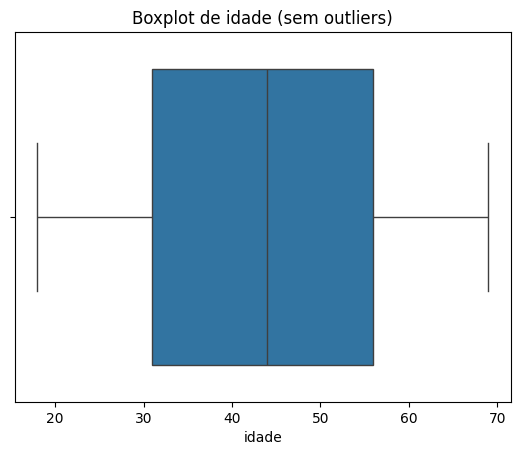

Outliers em salario: 40 outliers


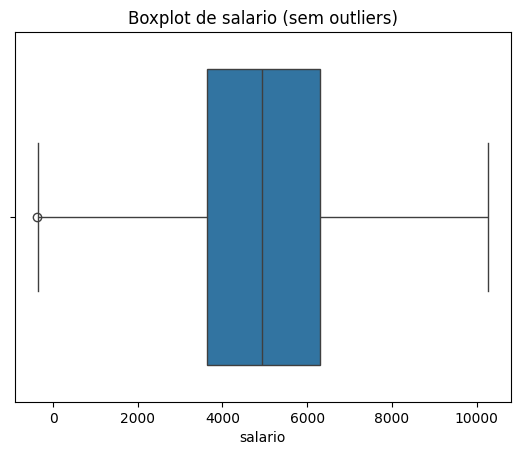

Outliers em tempo_emprego: 36 outliers


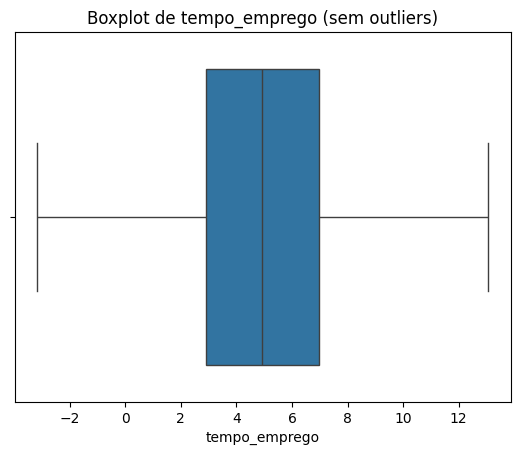

Outliers em score_credito: 39 outliers


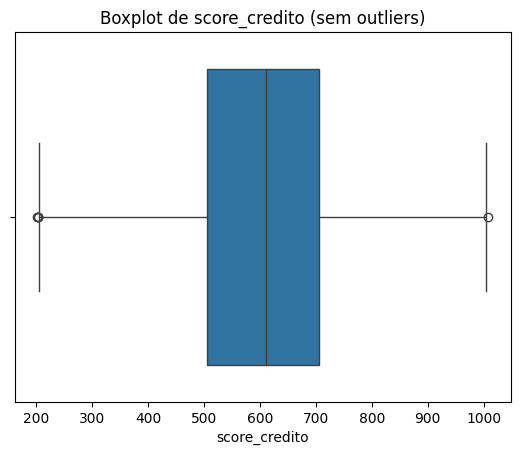

Outliers em limite_cartao: 51 outliers


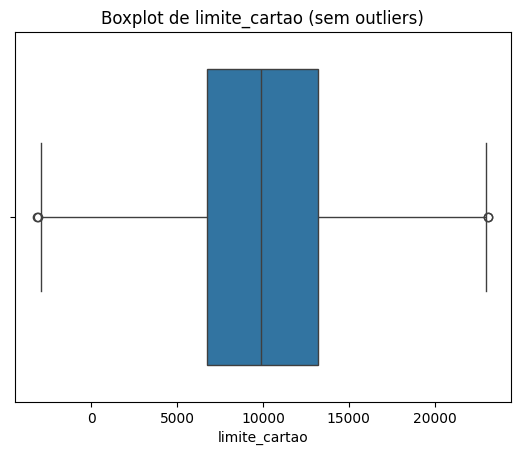

Outliers em dividas: 0 outliers


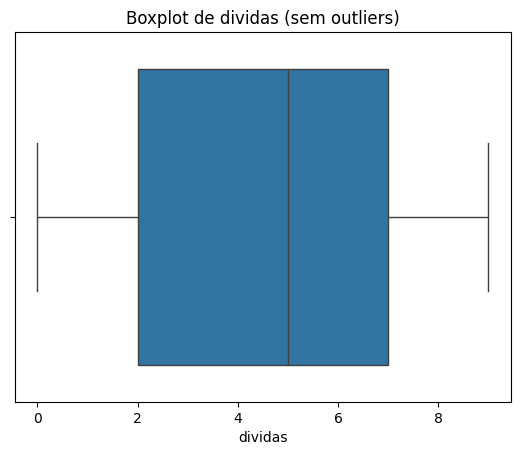

Outliers em numero_dependentes: 0 outliers


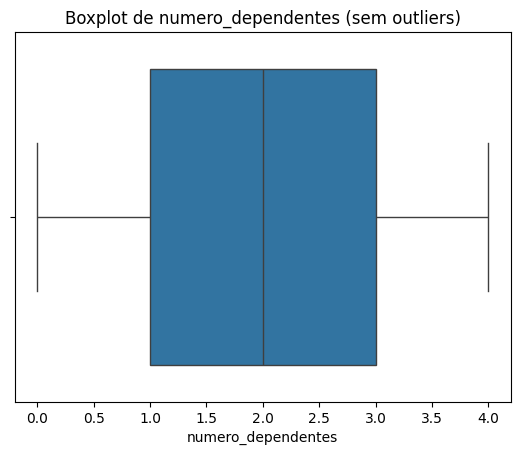

Outliers em renda_extra: 0 outliers


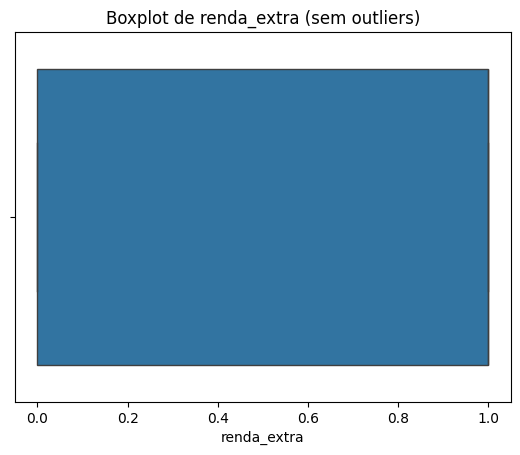

Outliers em possui_carro_sim: 0 outliers


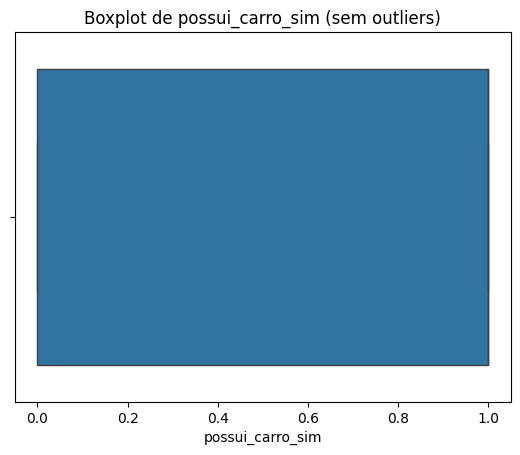

Outliers em possui_casa_sim: 0 outliers


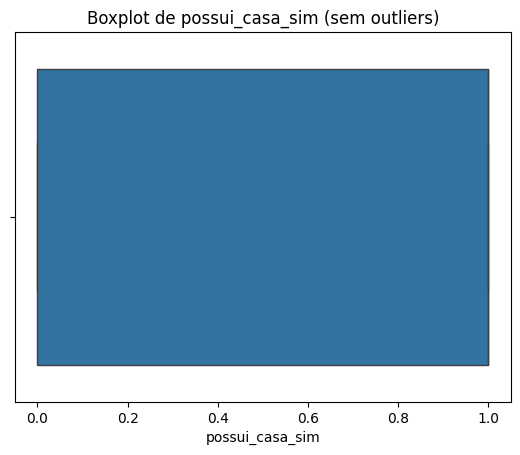

Outliers em estado_civil_divorciado: 503 outliers


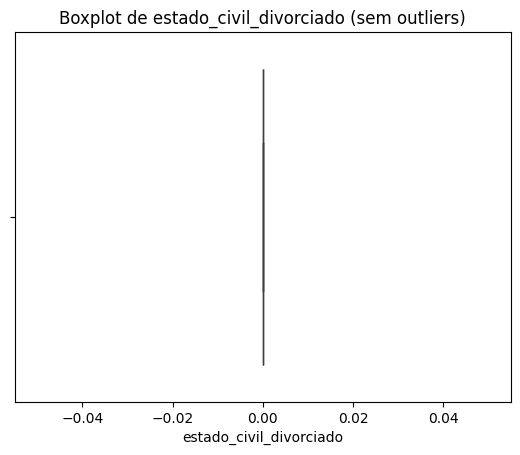

Outliers em estado_civil_solteiro: 0 outliers


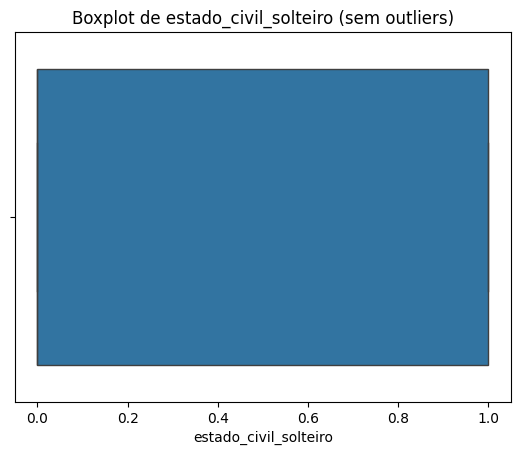

In [18]:
# Iterando sobre as variáveis numéricas
for col in num_vars:
    # Calculando o IQR para detectar outliers
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Identificando os outliers
    outliers = (df[col] < lower_bound) | (df[col] > upper_bound)
    
    # Contando os outliers
    outliers_count = outliers.sum()
    print(f'Outliers em {col}: {outliers_count} outliers')

    # Remover outliers do DataFrame
    df = df[~outliers]

    # Gerando o boxplot com os dados sem outliers
    sns.boxplot(x=df[col])
    plt.title(f"Boxplot de {col} (sem outliers)")
    plt.show()




conclusão:

Features com outliers:

- idade
- salario
- tempo emprego
- limite_cartão

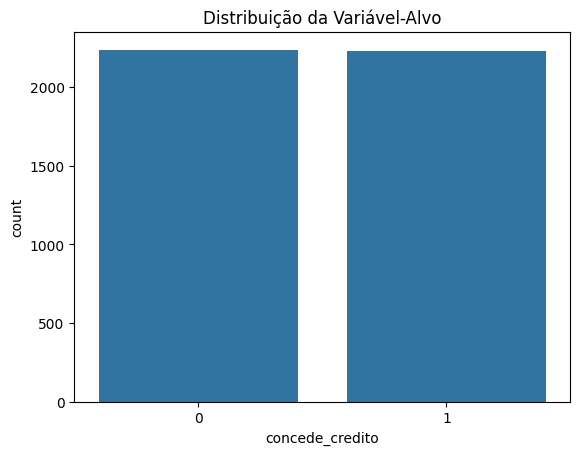

In [19]:
#analisando balanceamento das classes
sns.countplot(x=df["concede_credito"])
plt.title("Distribuição da Variável-Alvo")
plt.show()


# Divisão Treino e Teste

In [20]:
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter

In [38]:
# divisão dos dados em treino e teste

colunas_select = ['score_credito', 'tempo_emprego', 'limite_cartao', 'idade', 'salario']
x = df[colunas_select]
y = df.concede_credito

In [39]:
x_train, x_test, y_train, y_test = train_test_split (x,y, test_size= 0.2, random_state= 0)

In [40]:

print(f"Distribuição das classes no conjunto de treino antes do under-sampling: {Counter(y_train)}")
print(f"Distribuição das classes no conjunto de teste: {Counter(y_test)}")

Distribuição das classes no conjunto de treino antes do under-sampling: Counter({1: 1792, 0: 1783})
Distribuição das classes no conjunto de teste: Counter({0: 455, 1: 439})


In [41]:
# SMOTE aplciado a seguir não aceita valores NaN, portanto eles serão substituidos por média ou moda conforme o tipo de variável.

#colunas_numericas = ['salario' , 'tempo_emprego', 'limite_cartao' ]
colunas_numericas = ['tempo_emprego', 'limite_cartao' ]

In [42]:
x_train[colunas_numericas] = SimpleImputer(strategy='mean').fit_transform(x_train[colunas_numericas])

#Treinamento do modelo

In [43]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

In [91]:
model_tree = DecisionTreeClassifier (class_weight="balanced", max_depth=30)
model_tree.fit(x_train, y_train)
pred_tree = model_tree.predict(x_test)

In [93]:
print(classification_report(y_test, pred_tree))

              precision    recall  f1-score   support

           0       0.64      0.72      0.68       455
           1       0.66      0.57      0.62       439

    accuracy                           0.65       894
   macro avg       0.65      0.65      0.65       894
weighted avg       0.65      0.65      0.65       894



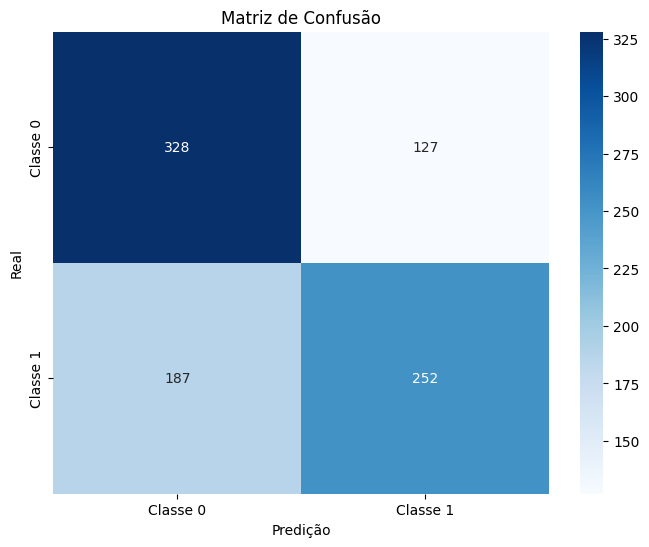

In [94]:

conf_matrix = confusion_matrix(y_test, pred_tree)

plt.figure(figsize=(8,6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Classe 0', 'Classe 1'], yticklabels=['Classe 0', 'Classe 1'])
plt.title('Matriz de Confusão')
plt.xlabel('Predição')
plt.ylabel('Real')
plt.show()

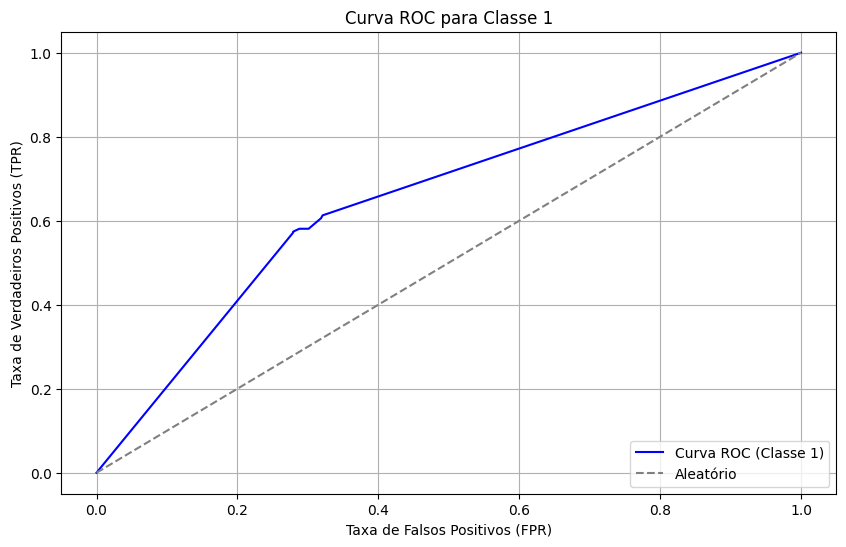

In [95]:

from sklearn.metrics import roc_curve

# Supondo que você já tenha um modelo treinado (decision_tree) e dados de teste (X_test, y_test)

# Obter as probabilidades previstas para cada classe
y_probs = model_tree.predict_proba(x_test)

# Calcular a curva ROC para a classe positiva (classe 1)
fpr, tpr, thresholds = roc_curve(y_test, y_probs[:, 1])

# Plotando a curva ROC
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, label='Curva ROC (Classe 1)', color='b')
plt.plot([0, 1], [0, 1], linestyle='--', label='Aleatório', color='gray')
plt.xlabel('Taxa de Falsos Positivos (FPR)')
plt.ylabel('Taxa de Verdadeiros Positivos (TPR)')
plt.title('Curva ROC para Classe 1')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()


In [97]:
import numpy as np
from sklearn.metrics import f1_score

# Supondo que 'model' seja seu modelo treinado e 'X_test' e 'y_test' sejam os dados de teste

# Passo 1: Obter as probabilidades para a classe 1
y_probs = model_tree.predict_proba(x_test)[:, 1]

# Passo 2: Definir um intervalo de valores de threshold (ex: de 0 a 1 com passos de 0.01)
thresholds = np.arange(0.0, 1.1, 0.01)

# Passo 3: Calcular o F1 score para cada threshold
f1_scores = []
for threshold in thresholds:
    y_pred = (y_probs >= threshold).astype(int)  # Converte as probabilidades em previsões binárias
    f1 = f1_score(y_test, y_pred)
    f1_scores.append(f1)

# Passo 4: Encontrar o threshold que maximiza o F1 score
best_threshold = thresholds[np.argmax(f1_scores)]
best_f1_score = max(f1_scores)

print(f"O melhor threshold é: {best_threshold}")
print(f"F1 score para esse threshold é: {best_f1_score}")


O melhor threshold é: 0.0
F1 score para esse threshold é: 0.6586646661665416


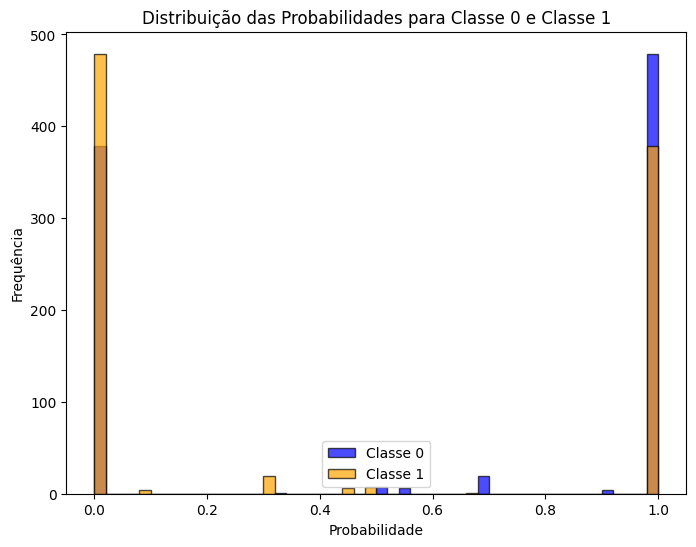

In [100]:
import matplotlib.pyplot as plt

# Supondo que 'y_probs' sejam as probabilidades para a classe 1
# 'model.predict_proba(X_test)[:, 0]' são as probabilidades para a classe 0

# Probabilidades para a classe 1
y_probs_class_1 = model_tree.predict_proba(x_test)[:, 1]

# Probabilidades para a classe 0
y_probs_class_0 = model_tree.predict_proba(x_test)[:, 0]

# Plotando as distribuições das probabilidades para as duas classes em um único gráfico
plt.figure(figsize=(8, 6))

# Histograma para a classe 0 (em azul)
plt.hist(y_probs_class_0, bins=50, edgecolor='k', alpha=0.7, color='blue', label='Classe 0')

# Histograma para a classe 1 (em laranja)
plt.hist(y_probs_class_1, bins=50, edgecolor='k', alpha=0.7, color='orange', label='Classe 1')

# Adicionando título, rótulos e legenda
plt.title('Distribuição das Probabilidades para Classe 0 e Classe 1')
plt.xlabel('Probabilidade')
plt.ylabel('Frequência')
plt.legend()

plt.show()

